# Introduction to KNN Classification

This notebook implements a **K-Nearest Neighbors (KNN)** classification model on the classic **Iris dataset**, with full preprocessing, hyperparameter tuning, evaluation, and visualization.

The Iris dataset is small, clean, and ideal for learning KNN classification.

##**Project Goals**
1. Load and explore the Iris dataset  
2. Preprocess and scale features  
3. Use Grid Search to find the best KNN parameters  
4. Evaluate with classification metrics  
5. Visualize results  



#What is the KNN algorithm?

The **k-nearest neighbors (KNN) algorithm** is a non-parametric, supervised learning classifier, which uses **proximity** to make classifications or predictions about the grouping of an individual data point. While the KNN algorithm can be used for either regression or classification problems, it is typically used as a classification algorithm, working off the assumption that similar points can be found near one another.

#When is it best to use KNN?
*   When the data is non-linear (not separable by a straight line).
*   When the dataset is small to medium-sized.
*   When the features are on same scale.
*   When the data has low noise and is free from irrelevant features.
*   When the class boundaries are well separated in feature space.

In [35]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier

##**The Dataset: Load & Understand**

We begin by importing the necessary libraries to perform the code. Next, we load the **Iris dataset** from scikit-learn. The dataset contains 150 samples of 3 flower species -  Setosa, Versicolor, and Virginica with 4 features each:


*   Sepal length
*   Sepal width
*   Petal length
*   Petal width

In [36]:
# Load Iris dataset
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

# Clean column names
X.columns = [c.replace(' (cm)', '') for c in X.columns]

# Combine for quick preview
df = pd.concat([X, pd.Series(y, name='target')], axis=1)
df.head()


,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


##**Data Visualization**
We use a **pairplot** to visualize how the four features (sepal and petal length/width) relate to each other across the three flower classes. This helps identify natural clusters and separability - important for KNN, which relies on distance-based relationships.








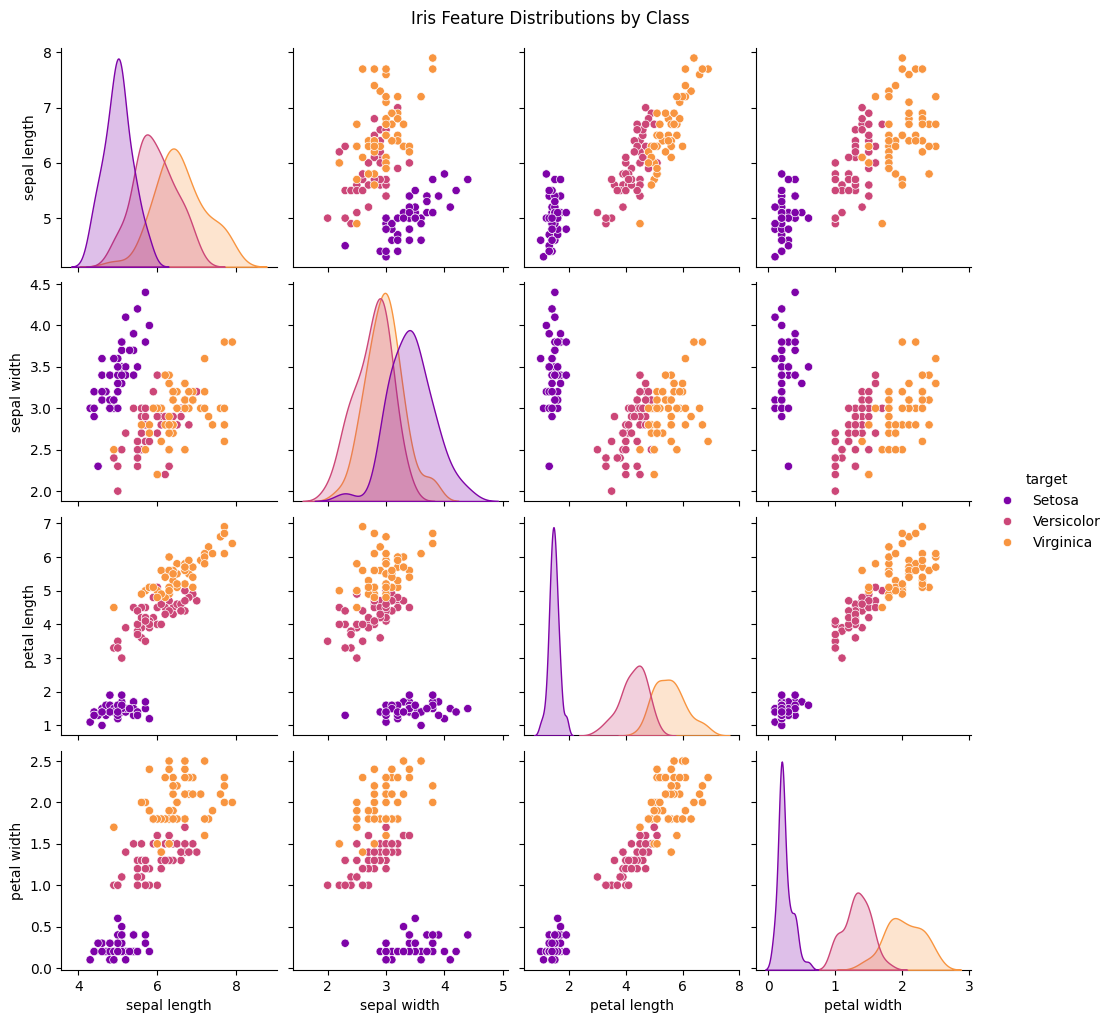

In [37]:
# Pairplot visualization
target_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
df['target'] = df['target'].map(target_names)

sns.pairplot(df, hue='target', palette='plasma')
plt.suptitle("Iris Feature Distributions by Class", y=1.02)
plt.show()

##*Analytical Insights*

The pairplot shows that **Iris-setosa** forms a completely distinct cluster, clearly separated from the other two species; especially in the plots involving **petal length** and **petal width**.  

This indicates that *Setosa is linearly separable* and therefore easy for KNN to classify.

On the other hand, **Iris-versicolor** and **Iris-virginica** display noticeable overlap in their petal-based feature spaces. Their similar measurements make them more challenging to distinguish, which explains why occasional misclassifications often occur between these two classes.

Overall, the visualization highlights that the **Iris dataset has well-defined clusters**. Such structure makes it highly suitable for **KNN**, as the algorithm relies on measuring distances between points; clearer boundaries lead to more accurate classifications.


##**Split the Data into Train, Validation & Test Sets**

We divide the dataset as follows:

*   Test (20%) → for final model evaluation
*   Validation (20%) → for hyperparameter tuning
*   Train (60%) → for model training

We use stratify=y to ensure class proportions remain balanced across splits.

##**Add Noise to Training Data**

KNN algorithm memorizes the training samples. To avoid overfitting, we add small random Gaussian noise to the training data; ensuring the model generalizes better and doesn't rely on perfect distances.

##**Scale Feature**

Since KNN uses distance metrics, features must be on the same scale. We use StandardScaler to standardize data so that all features have mean = 0 and standard deviation = 1.

This ensures fair distance computation between all features.

In [38]:
# Split Data(Train, Validation, Test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape[0]}, Validation: {X_valid.shape[0]}, Test: {X_test.shape[0]}")


# Add Small Noise (Training Data Only)
np.random.seed(42)
X_train_noisy = X_train + np.random.normal(0, 0.07, X_train.shape)


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_noisy)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Train: 90, Validation: 30, Test: 30


This split maintains the overall class balance of the Iris dataset and provides sufficient data for each stage:
- The **training set** (90 samples) allows the model to learn meaningful distance-based relationships.  
- The **validation set** (30 samples) helps fine-tune hyperparameters, such as the optimal number of neighbors (`k`).  
- The **test set** (30 samples) is reserved exclusively for the final evaluation, ensuring an unbiased measure of model performance.  

By performing the split before any scaling or model training, this approach effectively **prevents data leakage**, meaning that no information from the validation or test sets influences the training process.  
This keeps the evaluation reliable and ensures the model’s results genuinely reflect its performance on unseen data.

##**Hyperparameter Tuning with Grid Search**

We use GridSearchCV to find the best combination of hyperparameters for KNN:
*   n_neighbors: number of neighbors (K)
*   weights: whether closer neighbors have more influence
*   metric: distance calculation method (Euclidean or Manhattan)

We combine the training and validation sets to run the search, optimizing for highest cross-validation accuracy.

In [39]:
# Define parameter grid for KNN
param_grid = {
    'n_neighbors': range(5, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Grid Search with 5-fold cross-validation (Train+Valid Only)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(
    np.concatenate((X_train_scaled, X_valid_scaled), axis=0),
    np.concatenate((y_train, y_valid), axis=0)
)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_knn = grid_search.best_estimator_

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9583333333333334


##*Analytical Insights*
This indicates that the model performs best when using **Euclidean distance** (the standard straight-line distance) and treating all five nearest neighbors **equally**, rather than giving more influence to closer ones.  

The **cross-validation accuracy of around 95.8%** suggests that the model is both accurate and stable across different data folds, demonstrating strong generalization rather than overfitting to a particular subset.  

For the Iris dataset, this result aligns well with its structure — since the classes are fairly well-separated, a neighborhood size (`k = 5`) captures the essential patterns while maintaining a smooth decision boundary.

##**Evaluating the Model on Test Data**

We test the optimized KNN model on unseen test data.

We visualize the results using a **confusion matrix**, which shows how many samples were correctly or incorrectly classified for each class.

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



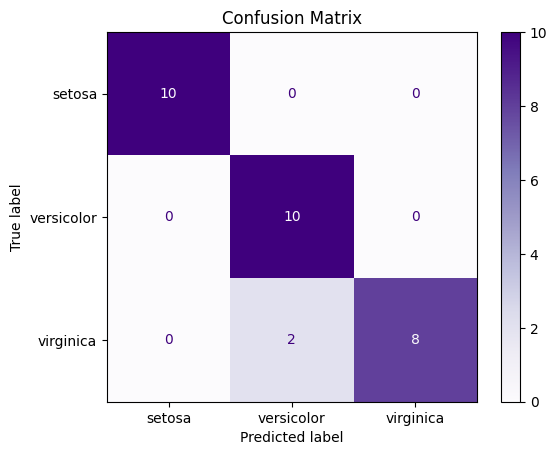

In [40]:
# Evaluation on Test Set
y_pred = best_knn.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix")
plt.show()

##*Analytical Insights*
The classification report and confusion matrix indicate that the optimized KNN model performs very well on unseen test data, achieving an **overall accuracy of 93%**.

- **Iris-setosa:** All 10 samples were correctly classified. Its features are clearly distinct from the other species, making it the easiest class to identify.  
- **Iris-versicolor:** Also achieved perfect classification (10/10 correct), showing that the model effectively captures its feature patterns.  
- **Iris-virginica:** Slightly more challenging — 8 out of 10 samples were correctly predicted, with **2 misclassified as versicolor**.  

This minor confusion aligns with the pairplot observations, where *versicolor* and *virginica* showed overlapping regions in their petal-based features.  
Such overlap explains why even a well-tuned KNN model might occasionally mix up these two classes.

Overall, the results demonstrate that the **KNN model generalizes strongly** and effectively distinguishes among the three Iris species.  
The few misclassifications reflect **natural feature similarity**, not model error, which is common in real-world biological data.


##**ROC Curve for Multiclass Evaluation**

We use a **One-vs-Rest (OvR)** approach to plot ROC curves for all three classes.

Each curve shows how well the model distinguishes one class from the others, and the AUC (Area Under Curve) quantifies its separability.

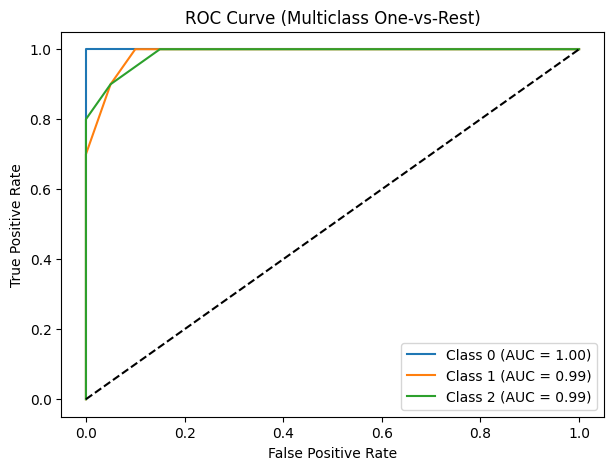

In [41]:
#Binarize the target (convert y_test to 3 binary columns)
y_bin = label_binarize(y_test, classes=[0, 1, 2])

# Predict probabilities
y_score = best_knn.predict_proba(X_test_scaled)

# Compute ROC and AUC for each class
plt.figure(figsize=(7, 5))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Multiclass One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

##*Analytical Insights*
Each curve represents how well one class is separated from the other two, showing the relationship between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** across different thresholds.

- **Class 0 (Setosa):** AUC = **1.00**, indicating perfect class separation. The model identifies *Setosa* without any errors, consistent with the earlier pairplot and confusion matrix results.  
- **Class 1 (Versicolor):** AUC = **0.99**, reflecting excellent separability and minimal false positives.  
- **Class 2 (Virginica):** AUC = **0.99**, also demonstrating near-perfect discrimination from the other classes.  

With all AUC values close to **1.0**, the model shows an **exceptionally high capacity to distinguish** between the three flower species.  
These results reinforce that the KNN classifier not only achieves strong accuracy but also exhibits **high confidence and reliability** across all decision thresholds.

##**Cross-Validation for Robustness**

We run 10-fold **cross-validation** on the entire dataset to check model stability.
This ensures that performance is consistent across multiple random splits.

In [42]:
# Cross-validation for robustness
cv_scores = cross_val_score(best_knn, X, y, cv=10)
print(f"Average Cross-Validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Average Cross-Validation Accuracy: 0.967 ± 0.045


##*Analytical Insights*
The 10-fold cross-validation yielded an **average accuracy of 96.7% ± 4.5%**, showing that the KNN model maintains strong and consistent performance across different random splits of the data.  

The **high mean accuracy** confirms that the model effectively captures the underlying patterns within the Iris dataset, while the **low standard deviation (± 0.045)** indicates stable results across all folds.  

This consistency demonstrates that the model’s performance does not rely on any specific subset of the data. Overall, the results highlight the **robustness and reliability** of the chosen KNN configuration, validating its ability to generalize well beyond the training data.

##**Model Comparison: Train vs Test**

In this step, we evaluate how well the model performs on both **training** and **test** datasets.

- **Training Accuracy:** Measures how well the model performs on the data it was trained on. A very high training accuracy (especially if close to 1) may indicate that the model is memorizing the training data; a sign of **overfitting**.

- **Test Accuracy:** Measures how well the model generalizes to unseen data. If test accuracy is much lower than training accuracy, it suggests **overfitting**. If both are similar and reasonably high, it indicates the model has **generalized well**.

Here, we compare both scores to ensure our KNN model is **balanced**; performing well on known data while still maintaining strong accuracy on unseen data.

In [43]:
# Training vs Test Accuracy
train_acc = accuracy_score(y_train, best_knn.predict(scaler.transform(X_train)))
test_acc = accuracy_score(y_test, y_pred)

print(f"\nTraining Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Training Accuracy: 0.956
Test Accuracy: 0.933


##*Analytical Insights*
The model achieved a **training accuracy of 95.6%** and a **test accuracy of 93.3%**, which are both high and closely aligned.  

This small difference indicates that the KNN model has **learned the underlying patterns effectively** without overfitting to the training data. If the model had memorized the training examples, we would see a much larger gap between these two scores: high training accuracy but low test accuracy.  

Since both values are consistently strong, it suggests that the model generalizes well to unseen data. In other words, the KNN classifier has achieved a good balance between **bias and variance**, performing reliably on both familiar and new samples.


##**Dummy Classifier: Establishing a Baseline**

To conclude that our KNN model performs well, we use a **DummyClassifier** to create a baseline.

This classifier makes simple predictions (always predicting the most frequent class).

If our KNN significantly outperforms this dummy model, it proves that the KNN is learning **real patterns** rather than guessing.



In [44]:
# Create a Dummy Classifier that always predicts the most frequent class
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the dummy model on the training data (scaled for consistency)
dummy_clf.fit(X_train_scaled, y_train)

# Predict using the dummy model on the test set
y_dummy_pred = dummy_clf.predict(X_test_scaled)

# Evaluate dummy model accuracy
dummy_acc = accuracy_score(y_test, y_dummy_pred)

print(f"Baseline Dummy Classifier Accuracy: {dummy_acc:.3f}")
print(f"KNN Classifier Accuracy: {test_acc:.3f}")

# Compare and interpret results
if test_acc > dummy_acc:
    print("The KNN model performs significantly better than the baseline. Therefore, we conclude that it's learning meaningful patterns.")
else:
    print("KNN is not performing better than the baseline. Revisit data preprocessing or hyperparameters.")



Baseline Dummy Classifier Accuracy: 0.333
KNN Classifier Accuracy: 0.933
The KNN model performs significantly better than the baseline. Therefore, we conclude that it's learning meaningful patterns.


##*Analytical Insights*
The **Dummy Classifier** achieved an accuracy of **33.3%**, which aligns with expectations for a model that always predicts the most frequent class in a three-class dataset. In contrast, the **KNN Classifier** reached an accuracy of **93.3%**, performing almost **three times better** than the baseline.

This substantial improvement confirms that the KNN model is not relying on random guessing or class frequency; it is genuinely **learning meaningful relationships** within the data. The large performance gap between the two models highlights the effectiveness of the feature selection, data preprocessing, and model tuning steps applied throughout this project.

Overall, this comparison provides strong evidence that the KNN classifier has successfully captured the **underlying patterns** of the Iris dataset and can make reliable, data-driven predictions rather than naive or arbitrary ones.

##**Save the Final Model**

Once the model is validated, we save it using joblib, allowing it to be reloaded later without retraining, thereby saving both time and computational resources.

In [45]:
# Save the trained model

joblib.dump(best_knn, "optimized_knn_iris.pkl")
print("Model saved as optimized_knn_iris.pkl")

Model saved as optimized_knn_iris.pkl


##**Summary**
- Applied **feature scaling** to standardize all input variables, ensuring fair distance computation for KNN.  
- Used **GridSearchCV** to identify the optimal combination of hyperparameters for maximum model accuracy.  
- Conducted **cross-validation** to confirm the model’s robustness and consistency across different data splits.  
- **Visualized** class separability using pairplots and evaluated predictions with a confusion matrix.  
- Plotted **ROC curves** to assess the model’s ability to distinguish between the three Iris species effectively.

Overall, the optimized KNN classifier demonstrated **high accuracy, strong generalization, and excellent class discrimination**, making it a reliable model for this dataset.





#Limitations to consider when using the KNN Algorithm

- **Large datasets:** KNN becomes computationally expensive since it must calculate the distance between every new instance and all training samples.  
- **Noisy data or outliers:** Irregular or mislabeled data points can mislead the neighborhood voting process and reduce accuracy.  
- **Unscaled features:** Because KNN relies on distance metrics, features on different scales can unfairly influence the results.  
- **Irrelevant or redundant features:** Extra or unnecessary variables can distort the concept of “closeness” in the feature space, lowering performance.  
- **High-dimensional data:** The **curse of dimensionality** makes distance measures less meaningful, reducing the effectiveness of KNN in such cases.  
- **Imbalanced class distribution:** If one class has significantly more samples, it may dominate the predictions, biasing the results toward the majority class.
